In [1]:
import os
import time
import glob
import time

import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import imageio as io
import PIL
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from IPython import display

2023-05-10 18:08:38.128498: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-10 18:08:39.585896: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-10 18:08:42.540809: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
IMG_WIDTH = 28
IMG_HEIGHT = 28
# img_folder = r'/home/hkolstee/uniprojects/hwRecog/data/monkbrill'
# output_path = r'/home/hkolstee/uniprojects/hwRecog/data/monkbrill_augm'
img_folder = r'/home/hkolstee/uniprojects/Data/HWR/monkbrill'
# output_path = r''

### Load dataset

In [3]:
def create_dataset(img_folder):
   
    img_data_array= []
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
            image_path = os.path.join(img_folder, dir1,  file)
            image = cv2.imread(image_path, -1)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
            # if image is not grayscale
            if (image.shape != (28, 28)):
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # invert
            image = cv2.bitwise_not(image)
            image = np.array(image)
            image = image.astype('float32')
            image /= 255 
            img_data_array.append(image)
            class_name.append(dir1)
            
    return img_data_array, class_name

In [4]:
# image array and class name
img_data, class_name = create_dataset(img_folder)

x = np.array(img_data, dtype = np.float32)

Check data

In [5]:
classes, counts = np.unique(class_name, return_counts = True)

data_dict = {}
for (key, value) in zip(classes, counts):
    data_dict[key] = value
    
print(f"Unique classes and number of images:")
data_dict

Unique classes and number of images:


{'Alef': 300,
 'Ayin': 300,
 'Bet': 300,
 'Dalet': 91,
 'Gimel': 300,
 'He': 300,
 'Het': 300,
 'Kaf': 193,
 'Kaf-final': 10,
 'Lamed': 294,
 'Mem': 300,
 'Mem-medial': 300,
 'Nun-final': 130,
 'Nun-medial': 300,
 'Pe': 37,
 'Pe-final': 15,
 'Qof': 265,
 'Resh': 78,
 'Samekh': 300,
 'Shin': 300,
 'Taw': 300,
 'Tet': 300,
 'Tsadi-final': 73,
 'Tsadi-medial': 300,
 'Waw': 116,
 'Yod': 23,
 'Zayin': 12}

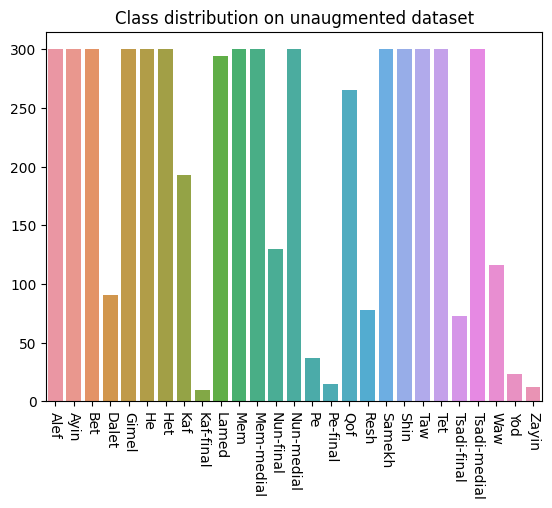

In [6]:
df = pd.DataFrame(data_dict, index=[0])
fig = sns.barplot(df)
fig.set_xticklabels(fig.get_xticklabels(), rotation=-90, horizontalalignment='center')
fig.set(title="Class distribution on unaugmented dataset")
plt.show()

Normalize images

In [7]:
# print(x[1])
x = tf.image.per_image_standardization(x)
# print(x)

2023-05-10 18:08:51.579698: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-10 18:08:52.248178: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Create generator and Discriminator
Generator: upsampling using Conv2DTranspose layers
Discriminator: Conv network

In [8]:
def createGenerator():
    model = tf.keras.Sequential()
    # layer that takes (random) seed as input
    model.add(layers.Dense(7 * 7 * 256, use_bias = False, input_shape = (100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # (Batch_size, x, y, z)

    # upsample
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # upsample
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # last upsample layer 
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    model.add(layers.Reshape((28, 28)))
    assert model.output_shape == (None, 28, 28)

    return model

In [9]:
def createDiscriminator():
    model = tf.keras.Sequential()
    # first convolutional layer
    model.add(layers.Reshape((28, 28, 1))) # 28 x 28 -> 28 x 28 x 1
    model.add(layers.Conv2D(64, (5, 5), strides = (2, 2), padding = 'same', input_shape = (28, 28, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # second convolutional layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # output layer -> positive values for real decision, negative for fake decision
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Create models

In [10]:
generator_model = createGenerator()
discrim_model = createDiscriminator()

Test untrained networks

(1, 28, 28)
tf.Tensor([[-0.00116215]], shape=(1, 1), dtype=float32)


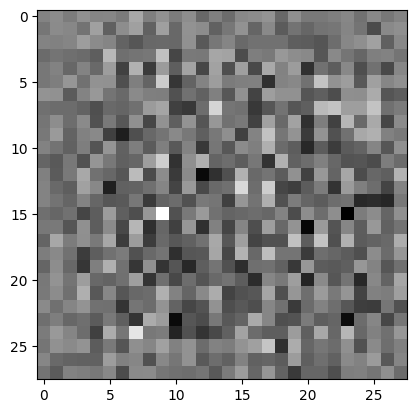

In [11]:
# input noise into generator -> output also noise as it is untrained
noise = tf.random.normal([1, 100])
generated_image = generator_model(noise, training=False)
print(generated_image.shape)

plt.imshow(generated_image[-1], cmap='gray')

# input noise into discriminator -> random output value (positive = real, negative = fake)
decision = discrim_model(generated_image)
print(decision)


Loss function and optimizers for both models.   
The loss functions take as input the discriminators predictions/decisions (array or single value) on real/fake images.

In [12]:
# define cross-entropy helper loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def generatorLoss(fake_output_decisions):
    return cross_entropy(tf.ones_like(fake_output_decisions), fake_output_decisions)

# compares real images to an array of 1's, and fake images to array of 0's 
def discrimLoss(real_output_decisions, fake_output_decisions):
    real_loss = cross_entropy(tf.ones_like(real_output_decisions), real_output_decisions)
    fake_loss = cross_entropy(tf.zeros_like(fake_output_decisions), fake_output_decisions)
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
generator_optim = tf.keras.optimizers.Adam(0.0001)
discrim_optim = tf.keras.optimizers.Adam(0.0001)

Checkpointing

In [14]:
checkpoint_dir = os.path.join("../Data/HWR/GAN_checkpoints", "ckpt")
checkpoint = tf.train.Checkpoint(gen_optim = generator_optim, discrim_optim = discrim_optim, generator_model = generator_model, discrim_model = discrim_model)

### Train loop

In [15]:
nr_epochs = 100
nr_noisy_img =  100
nr_img_to_generate = 16
batch_size = 256

In [16]:
def step(images):
    noise = tf.random.normal((batch_size, nr_noisy_img))

    # keep track of output gradients using gradienttape
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discrim_tape:
        # generate images from the noise images using the generator
        generated_imgs = generator_model(noise, training = True)

        # judge real images and generated images using the discriminator
        real_ouput_decisions = discrim_model(images, training = True)
        fake_output_decisions = discrim_model(generated_imgs, training = True)

        # calculate loss based on the decisions of the discriminator
        generator_loss = generatorLoss(fake_output_decisions)
        discrim_loss = discrimLoss(real_ouput_decisions, fake_output_decisions)

    # get gradients from tape
    generator_grads = generator_tape.gradient(generator_loss, generator_model.trainable_variables)
    discrim_grads = discrim_tape.gradient(discrim_loss, discrim_model.trainable_variables)

    # take step along gradients
    generator_optim.apply_gradients(zip(generator_grads, generator_model.trainable_variables))
    discrim_optim.apply_gradients(zip(discrim_grads, discrim_model.trainable_variables))

In [17]:
def train(x, epochs):
    for epoch in (progress_bar := tqdm(range(1, nr_epochs))):
        # add epoch info to progress bar
        progress_bar.set_description(f"Epoch {epoch}")

        # take a gradient step for a batch
        for offset in range(0, len(x), batch_size):
            step(x[offset : offset + batch_size])
        
        # save model every 10 epochs
        if ((epoch % 10) == 0):
            checkpoint.save(checkpoint_dir)

        # print time
        # print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

train the model

In [18]:
train(x, nr_epochs)

Epoch 2:   1%|          | 1/99 [02:01<3:18:43, 121.66s/it]


KeyboardInterrupt: 

### Generate some output with the trained model

In [ ]:
def display_images(image_list, title):
    nr_images = len(image_list)
    
    # size of x axis in grid
    x = int(np.floor(np.sqrt(nr_images)))
    # size of y axis in grid
    y = int(np.ceil(nr_images/x))
    
    fig, axs = plt.subplots(x, y)
    axs = axs.flatten()
    for (image, ax) in zip(image_list, axs):
        ax.imshow(image, cmap = "Greys")
    
    fig.suptitle(title)
    plt.show()

In [ ]:
noise = tf.random.normal([20, 100])
generated_images = generator_model(noise, training=False)  

display_images(generated_images, "Some sample generated images by the generator after 100 epochs")